In [1]:
# IMPORT LIBRARIES
using Distributions, Turing, StatsPlots, Random, RDatasets

### Assignment 2: hierarchical models

In [2]:
# FETCH WARP BREAKS DATA SET
df = RDatasets.dataset("datasets", "warpbreaks")

,Breaks,Wool,Tension
,Int32,Cat…,Cat…
1,26,A,L
2,30,A,L
3,54,A,L
4,25,A,L
5,70,A,L
6,52,A,L
7,51,A,L
8,26,A,L
9,67,A,L


In [93]:
# DIVIDE BREAKS INTO GROUPS
breaks_a = df.Breaks[df.Wool .== "A"]
breaks_b = df.Breaks[df.Wool .== "B"]

27-element Array{Int32,1}:
 27
 14
 29
 19
 29
 31
 41
 20
 44
 42
 26
 19
 16
  ⋮
 21
 39
 29
 20
 21
 24
 17
 13
 15
 15
 16
 28

Infer the probability distribution of warp breaks for each of two wool types. Compare the results under separate and hierarchical models. Conduct two studies:

1. Ignore warp tension and compare wool types based on all experiments.
2. Account for warp tension in both the hierarchical model and the separate model.

#### Separate Model: Ignore wrap tension & Compare wool types based on all experiments

In [94]:
# WOOL SEPARATE MODEL OF TOTAL BREAKS FOR EACH TYPE
@model function wool_separate(breaks)    
    for i in eachindex(breaks)
        μ ~ Normal(20, 5)
        σ ~ Exponential(2)
        breaks[i] ~ Normal(μ, σ)
    end
end

wool_separate (generic function with 2 methods)

##### Breaks Data Groups A and B: Average and Std.

In [89]:
# AVERAGE BREAKS GROUP A
sum(breaks_a) / length(breaks_a)

31.037037037037038

In [90]:
# STD BREAKS GROUP A
std(breaks_a)

15.851429155372909

In [91]:
# AVERAGE BREAKS GROUP B
sum(breaks_b) / length(breaks_b)

25.25925925925926

In [92]:
# STD BREAKS GROUP B
std(breaks_b)

9.300920519342293

In [95]:
# CHAIN BREAKS OF TYPE A AND B
chn_a = sample(wool_separate(breaks_a), NUTS(), MCMCThreads(), 1000, 4)
chn_b = sample(wool_separate(breaks_b), NUTS(), MCMCThreads(), 1000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:228
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\nitsa\.julia\packages\Turing\PyTy2\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\nitsa\.julia\packages\Turing\PyTy2\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (t

LoadError: [91msyntax: missing comma or ) in argument list[39m

### Posterior of Breaks Types: A and B, under Separate Model, with out Wrap tension

##### Posterior Statistics of Groups A and B

In [103]:
print(
    "Posterior Statisitcs:\n",
    "Group A:\n",
    "μ Parameter:\n",
    "Average: ", sum(chn_a[:μ]) / length(chn_a[:μ]), "\n",
    "Std.: ", std(chn_a[:μ]),
    "\nσ Parameter:\n",
    "Average: ", sum(chn_a[:σ]) / length(chn_a[:σ]), "\n",
    "Std.: ", std(chn_a[:σ]), "\n\n",
    
    "Group B:\n",
    "μ Parameter:\n",
    "Average: ", sum(chn_b[:μ]) / length(chn_b[:μ]), "\n",
    "Std.: ", std(chn_b[:μ]),
    "\nσ Parameter:\n",
    "Average: ", sum(chn_b[:σ]) / length(chn_b[:σ]), "\n",
    "Std.: ", std(chn_b[:σ]), "\n\n"
)

Posterior Statisitcs:
Group A:
μ Parameter:
Average: 22.842257514346528
Std.: 0.850177680750431
σ Parameter:
Average: 8.538785049228045
Std.: 0.4801833192034901

Group B:
μ Parameter:
Average: 22.276470497814863
Std.: 0.7254322162647939
σ Parameter:
Average: 5.72835090727698
Std.: 0.3823083171873714



##### Posterior Plotting of Groups A and B

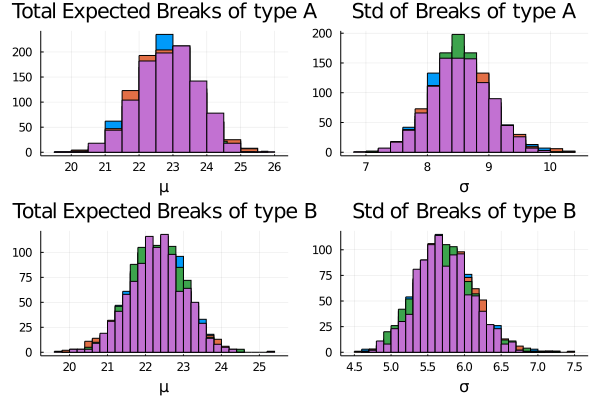

In [83]:
let
    plot(layout=4)
    histogram!(chn_a[:μ], xlabel="μ", label=missing,  subplot=1, title="Total Expected Breaks of type A")
    histogram!(chn_a[:σ], xlabel="σ", label=missing, subplot=2, title="Std of Breaks of type A")
    histogram!(chn_b[:μ], xlabel="μ", label=missing,  subplot=3, title="Total Expected Breaks of type B")
    histogram!(chn_b[:σ], xlabel="σ", label=missing, subplot=4, title="Std of Breaks of type B")
end

In [156]:
# WOOL SEPARATE MODEL OF TOTAL BREAKS FOR EACH TYPE
@model function wool_hirerchial(breaks_groups)
    τ ~ LogNormal(0, 10)  # Groups difference factor
    
    μ ~ Normal(20, 5)  # Breaks total average
    σ ~ Normal(5, 1)  # Breaks total std.
    η ~ MvNormal([0, 0], 1)  # Group difference
    
    θ = μ .+ τ .* η  # Constructed Hyperparameter

    for i in eachindex(breaks_groups)
        breaks = breaks_groups[i]
        
        for j in eachindex(breaks)
            breaks[j] ~ Normal(θ[i], σ)  # Error In Model
        end
    end
end

wool_hirerchial (generic function with 1 method)

In [155]:
# CHAIN BREAKS HIRERCHIAL
chn = sample(wool_hirerchial([breaks_a, breaks_b]), NUTS(), MCMCThreads(), 1000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:228


LoadError: [91mTaskFailedException:[39m
[91m[91mInexactError: Int32(-0.2233288095155741)[39m[39m
[91mStacktrace:[39m
[91m [1] [1mInt32[22m at [1m.\float.jl:689[22m [inlined][39m
[91m [2] [1mconvert[22m at [1m.\number.jl:7[22m [inlined][39m
[91m [3] [1msetindex![22m at [1m.\array.jl:847[22m [inlined][39m
[91m [4] [1m#73[22m at [1m.\In[154]:14[22m [inlined][39m
[91m [5] [1m(::var"#73#74")[22m[1m([22m::Random._GLOBAL_RNG, ::DynamicPPL.Model{var"#73#74",(:breaks_groups,),(),(),Tuple{Array{Array{Int32,1},1}},Tuple{}}, ::DynamicPPL.VarInfo{DynamicPPL.Metadata{Dict{DynamicPPL.VarName,Int64},Array{Distribution,1},Array{DynamicPPL.VarName,1},Array{Real,1},Array{Set{DynamicPPL.Selector},1}},Float64}, ::DynamicPPL.SampleFromUniform, ::DynamicPPL.DefaultContext, ::Array{Array{Int32,1},1}[1m)[22m at [1m.\none:0[22m[39m
[91m [6] [1mmacro expansion[22m at [1mC:\Users\nitsa\.julia\packages\DynamicPPL\wf0dU\src\model.jl:0[22m [inlined][39m
[91m [7] [1m_evaluate[22m at [1mC:\Users\nitsa\.julia\packages\DynamicPPL\wf0dU\src\model.jl:154[22m [inlined][39m
[91m [8] [1mevaluate_threadunsafe[22m at [1mC:\Users\nitsa\.julia\packages\DynamicPPL\wf0dU\src\model.jl:127[22m [inlined][39m
[91m [9] [1mModel[22m at [1mC:\Users\nitsa\.julia\packages\DynamicPPL\wf0dU\src\model.jl:92[22m [inlined][39m
[91m [10] [1mVarInfo[22m at [1mC:\Users\nitsa\.julia\packages\DynamicPPL\wf0dU\src\varinfo.jl:126[22m [inlined][39m
[91m [11] [1mVarInfo[22m at [1mC:\Users\nitsa\.julia\packages\DynamicPPL\wf0dU\src\varinfo.jl:125[22m [inlined][39m
[91m [12] [1mstep[22m[1m([22m::Random._GLOBAL_RNG, ::DynamicPPL.Model{var"#73#74",(:breaks_groups,),(),(),Tuple{Array{Array{Int32,1},1}},Tuple{}}, ::DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric}}; resume_from::Nothing, kwargs::Base.Iterators.Pairs{Symbol,Int64,Tuple{Symbol},NamedTuple{(:nadapts,),Tuple{Int64}}}[1m)[22m at [1mC:\Users\nitsa\.julia\packages\DynamicPPL\wf0dU\src\sampler.jl:73[22m[39m
[91m [13] [1mmacro expansion[22m at [1mC:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:78[22m [inlined][39m
[91m [14] [1mmacro expansion[22m at [1mC:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\logging.jl:15[22m [inlined][39m
[91m [15] [1mmcmcsample[22m[1m([22m::Random._GLOBAL_RNG, ::DynamicPPL.Model{var"#73#74",(:breaks_groups,),(),(),Tuple{Array{Array{Int32,1},1}},Tuple{}}, ::DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric}}, ::Int64; progress::Bool, progressname::String, callback::Nothing, discard_initial::Int64, thinning::Int64, chain_type::Type{T} where T, kwargs::Base.Iterators.Pairs{Symbol,Int64,Tuple{Symbol},NamedTuple{(:nadapts,),Tuple{Int64}}}[1m)[22m at [1mC:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:76[22m[39m
[91m [16] [1m#sample#40[22m at [1mC:\Users\nitsa\.julia\packages\Turing\PyTy2\src\inference\hmc.jl:133[22m [inlined][39m
[91m [17] [1mmacro expansion[22m at [1mC:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:280[22m [inlined][39m
[91m [18] [1m(::AbstractMCMC.var"#582#threadsfor_fun#50"{UnitRange{Int64},Bool,Base.Iterators.Pairs{Symbol,UnionAll,Tuple{Symbol},NamedTuple{(:chain_type,),Tuple{UnionAll}}},Int64,Array{Random._GLOBAL_RNG,1},Array{DynamicPPL.Model{var"#73#74",(:breaks_groups,),(),(),Tuple{Array{Array{Int32,1},1}},Tuple{}},1},Array{DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric}},1},Array{UInt64,1},Array{Any,1}})[22m[1m([22m::Bool[1m)[22m at [1m.\threadingconstructs.jl:81[22m[39m
[91m [19] [1m(::AbstractMCMC.var"#582#threadsfor_fun#50"{UnitRange{Int64},Bool,Base.Iterators.Pairs{Symbol,UnionAll,Tuple{Symbol},NamedTuple{(:chain_type,),Tuple{UnionAll}}},Int64,Array{Random._GLOBAL_RNG,1},Array{DynamicPPL.Model{var"#73#74",(:breaks_groups,),(),(),Tuple{Array{Array{Int32,1},1}},Tuple{}},1},Array{DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric}},1},Array{UInt64,1},Array{Any,1}})[22m[1m([22m[1m)[22m at [1m.\threadingconstructs.jl:48[22m[39m
[91mStacktrace:[39m
[91m [1] [1mwait[22m at [1m.\task.jl:267[22m [inlined][39m
[91m [2] [1mthreading_run[22m[1m([22m::Function[1m)[22m at [1m.\threadingconstructs.jl:34[22m[39m
[91m [3] [1mmacro expansion[22m at [1m.\threadingconstructs.jl:93[22m [inlined][39m
[91m [4] [1mmacro expansion[22m at [1mC:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:271[22m [inlined][39m
[91m [5] [1m(::AbstractMCMC.var"#35#49"{Bool,Base.Iterators.Pairs{Symbol,UnionAll,Tuple{Symbol},NamedTuple{(:chain_type,),Tuple{UnionAll}}},Int64,Int64,Array{Random._GLOBAL_RNG,1},Array{DynamicPPL.Model{var"#73#74",(:breaks_groups,),(),(),Tuple{Array{Array{Int32,1},1}},Tuple{}},1},Array{DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric}},1},Array{UInt64,1},Array{Any,1}})[22m[1m([22m[1m)[22m at [1m.\task.jl:356[22m[39m